In [1]:
import numpy as np
import pandas as pd
import h5py

data_path = "E:\Dataset\Cyclone Intensity Estimation\TCIR-ALL_2017\TCIR-ALL_2017.h5"

# load "info" as pandas dataframe
data_info = pd.read_hdf(data_path, key="info", mode='r')

# load "matrix" as numpy ndarray, this could take longer times
with h5py.File(data_path, 'r') as hf:
    data_matrix = hf['matrix'][:]

In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pandas.plotting import autocorrelation_plot
from haversine import haversine

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    GlobalAveragePooling2D, Reshape, MultiHeadAttention, Concatenate
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50, EfficientNetB0, EfficientNetB1, VGG16, VGG19


In [48]:
print("Total cyclones:", data_info['ID'].nunique())
print("Regions:", data_info['data_set'].unique())

Total cyclones: 94
Regions: ['ATLN' 'EPAC' 'IO' 'SH' 'WPAC']


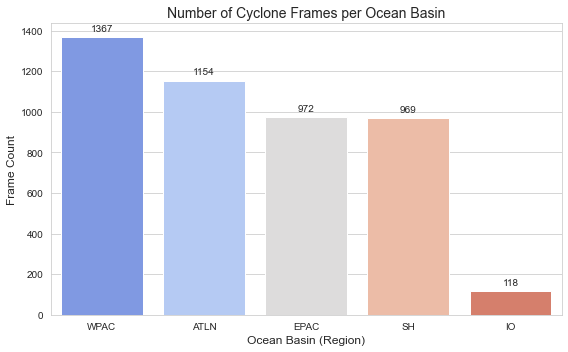

In [70]:
# Set plot style
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")

# Countplot with sorted order
region_counts = data_info['data_set'].value_counts().sort_values(ascending=False)
sns.barplot(x=region_counts.index, y=region_counts.values, palette="coolwarm")

# Add value annotations on top of bars
for i, val in enumerate(region_counts.values):
    plt.text(i, val + 20, str(val), ha='center', va='bottom', fontsize=10)

plt.title('Number of Cyclone Frames per Ocean Basin', fontsize=14)
plt.xlabel('Ocean Basin (Region)', fontsize=12)
plt.ylabel('Frame Count', fontsize=12)
plt.tight_layout()
plt.show()

Track length stats:
count     94.000000
mean      48.723404
std       32.796015
min        9.000000
25%       25.500000
50%       41.000000
75%       65.000000
max      169.000000
Name: ID, dtype: float64


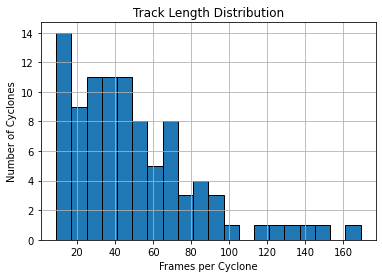

In [50]:
track_lengths = data_info['ID'].value_counts()
print("Track length stats:")
print(track_lengths.describe())

track_lengths.hist(bins=20, edgecolor='black')
plt.title('Track Length Distribution')
plt.xlabel('Frames per Cyclone')
plt.ylabel('Number of Cyclones')
plt.show()

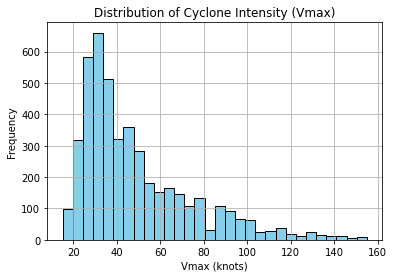

In [51]:
data_info['Vmax'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Cyclone Intensity (Vmax)')
plt.xlabel('Vmax (knots)')
plt.ylabel('Frequency')
plt.show()

In [52]:
example_id = data_info['ID'].value_counts().idxmax()  # longest cyclone
example_id

'201712L'

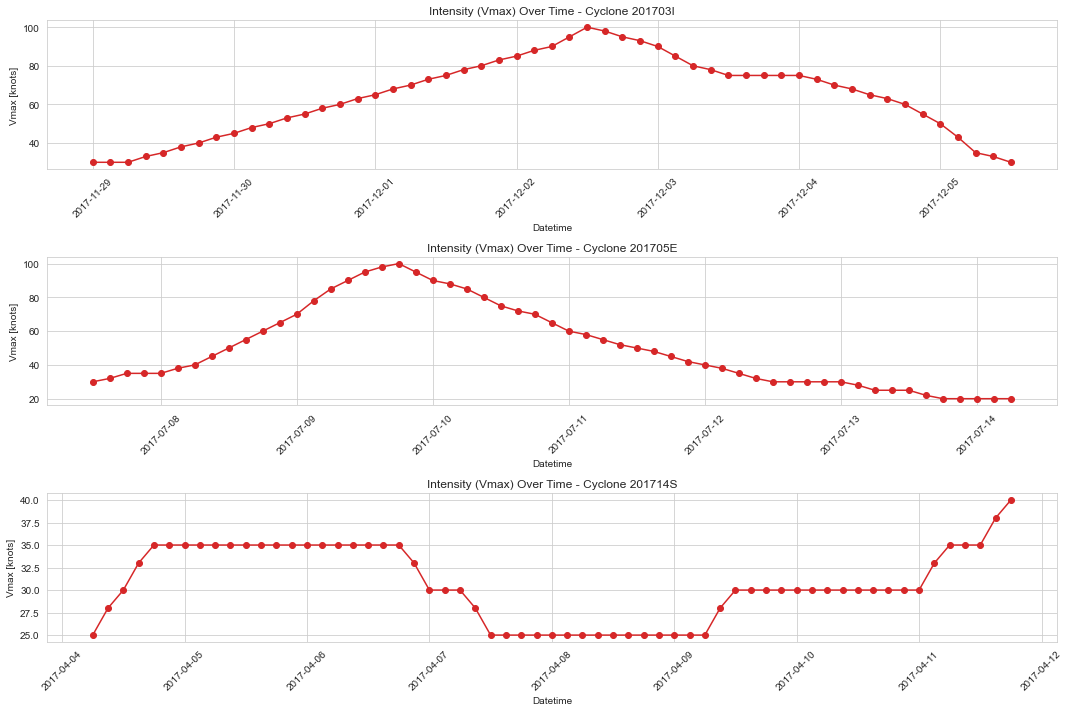

In [76]:
# Ensure datetime conversion
data_info['datetime'] = pd.to_datetime(data_info['time'], format='%Y%m%d%H')

# Select 3 cyclone IDs for plotting
example_ids = data_info['ID'].drop_duplicates().sample(3, random_state=42)

# Create subplots
fig, axs = plt.subplots(len(example_ids), 1, figsize=(15, 10), sharex=False)

for ax, cid in zip(axs, example_ids):
    track = data_info[data_info['ID'] == cid].sort_values('datetime')
    ax.plot(track['datetime'], track['Vmax'], marker='o', color='tab:red')
    ax.set_title(f'Intensity (Vmax) Over Time - Cyclone {cid}', fontsize=12)
    ax.set_xlabel('Datetime')
    ax.set_ylabel('Vmax [knots]')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

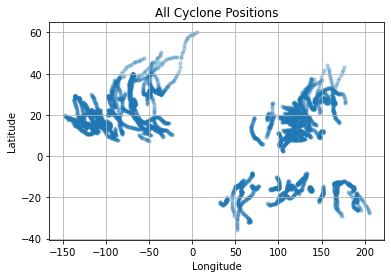

In [54]:
plt.scatter(data_info['lon'], data_info['lat'], alpha=0.3, s=10)
plt.title('All Cyclone Positions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

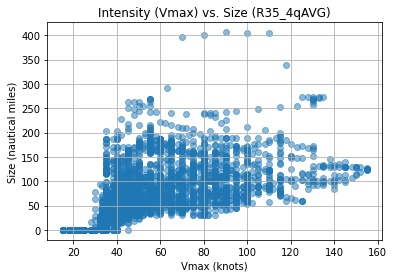

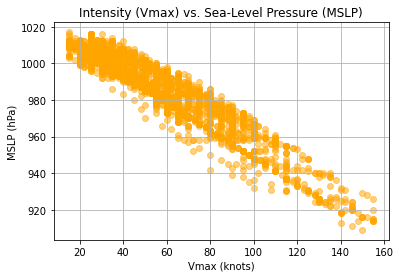

In [55]:
plt.scatter(data_info['Vmax'], data_info['R35_4qAVG'], alpha=0.5)
plt.title('Intensity (Vmax) vs. Size (R35_4qAVG)')
plt.xlabel('Vmax (knots)')
plt.ylabel('Size (nautical miles)')
plt.grid(True)
plt.show()

plt.scatter(data_info['Vmax'], data_info['MSLP'], alpha=0.5, color='orange')
plt.title('Intensity (Vmax) vs. Sea-Level Pressure (MSLP)')
plt.xlabel('Vmax (knots)')
plt.ylabel('MSLP (hPa)')
plt.grid(True)
plt.show()

In [56]:
print("Missing values per column:\n")
print(data_info.isnull().sum())

Missing values per column:

data_set     0
ID           0
lon          0
lat          0
time         0
Vmax         0
R35_4qAVG    0
MSLP         0
datetime     0
dtype: int64


## Track Continuity & Time Gaps

In [57]:
data_info['datetime'] = pd.to_datetime(data_info['time'], format="%Y%m%d%H")

def check_time_gaps(df, storm_id):
    track = df[df['ID'] == storm_id].sort_values('datetime')
    diffs = track['datetime'].diff().dt.total_seconds() / 3600  # hours
    return diffs.value_counts()

# Example on a cyclone
example_id = data_info['ID'].value_counts().idxmax()
print(check_time_gaps(data_info, example_id))


3.0    168
Name: datetime, dtype: int64


## Trajectory Plot with Intensity

In [58]:
def plot_cyclone_track(df, storm_id):
    track = df[df['ID'] == storm_id].sort_values('datetime')

    # Extract lat/lon and intensity
    lats = track['lat'].values
    lons = track['lon'].values
    vmax = track['Vmax'].values

    # Normalize intensity for color mapping
    norm = mcolors.Normalize(vmin=np.min(vmax), vmax=np.max(vmax))
    cmap = cm.get_cmap('plasma')

    plt.figure(figsize=(10, 6))

    # Plot segments of the track, color-coded by Vmax
    for i in range(1, len(track)):
        plt.plot(lons[i-1:i+1], lats[i-1:i+1], color=cmap(norm(vmax[i])), linewidth=3)

    # Start and end points
    plt.scatter(lons[0], lats[0], color='green', s=100, label='Start', zorder=5)
    plt.scatter(lons[-1], lats[-1], color='red', s=100, label='End', zorder=5)

    # Optional annotations (every 5 steps)
    for i in range(0, len(track), 5):
        plt.text(lons[i], lats[i], str(i), fontsize=8, ha='right')

    # Colorbar for Vmax
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Maximum Sustained Wind Speed (Vmax) [knots]')

    # Labels and styling
    plt.title(f'Track of Cyclone {storm_id} with Intensity')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

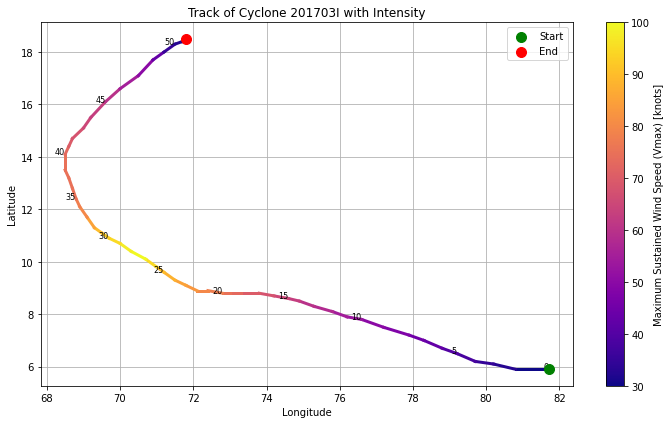

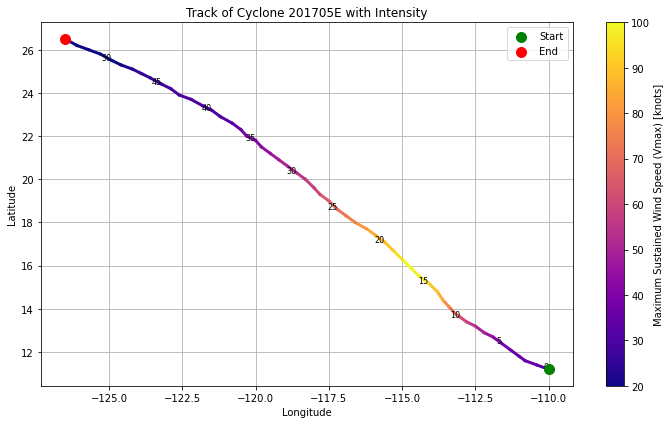

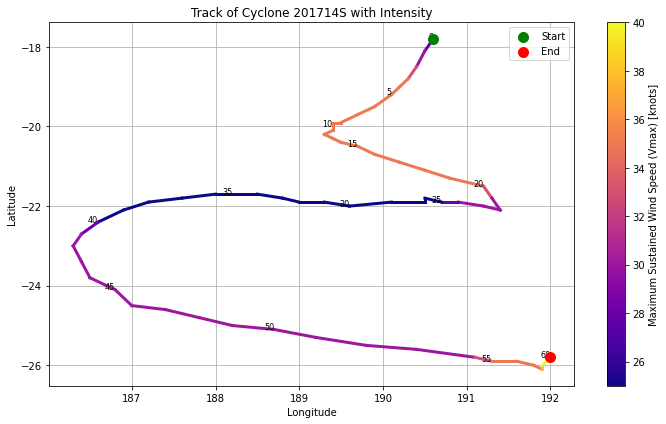

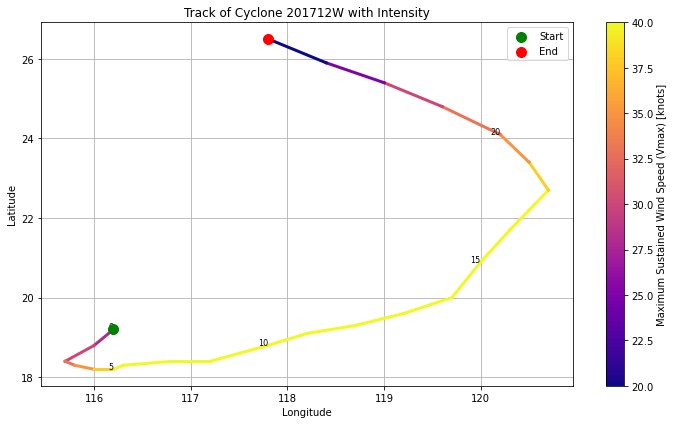

In [59]:
# Plot 3–4 random cyclones beautifully
for cid in data_info['ID'].drop_duplicates().sample(4, random_state=42):
    plot_cyclone_track(data_info, cid)

## Trajectory Plot with Size

In [60]:
def plot_cyclone_track_with_size(df, storm_id):
    track = df[df['ID'] == storm_id].sort_values('datetime')

    # Extract lat/lon, intensity, and size
    lats = track['lat'].values
    lons = track['lon'].values
    vmax = track['Vmax'].values
    size = track['R35_4qAVG'].values

    # Normalize intensity for color mapping
    norm = mcolors.Normalize(vmin=np.min(vmax), vmax=np.max(vmax))
    cmap = cm.get_cmap('plasma')

    # Normalize size for marker sizes
    size_scaled = 20 + 100 * (size - np.min(size)) / (np.max(size) - np.min(size))  # range: 20–120

    plt.figure(figsize=(10, 6))

    # Plot each point as a colored circle (by Vmax), sized by R35_4qAVG
    for i in range(len(track)):
        plt.scatter(lons[i], lats[i], s=size_scaled[i], 
                    color=cmap(norm(vmax[i])), edgecolor='black', alpha=0.8)

    # Start and end points
    plt.scatter(lons[0], lats[0], color='green', s=150, label='Start', zorder=5, edgecolor='black')
    plt.scatter(lons[-1], lats[-1], color='red', s=150, label='End', zorder=5, edgecolor='black')

    # Colorbar for intensity
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Maximum Sustained Wind Speed (Vmax) [knots]')

    # Labels and styling
    plt.title(f'Cyclone Track with Intensity and Size - {storm_id}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

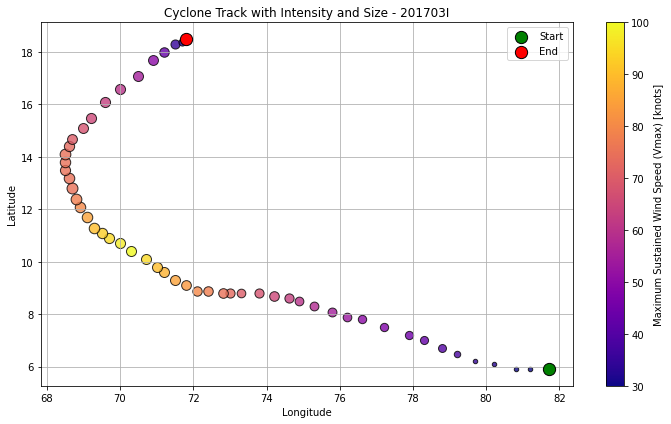

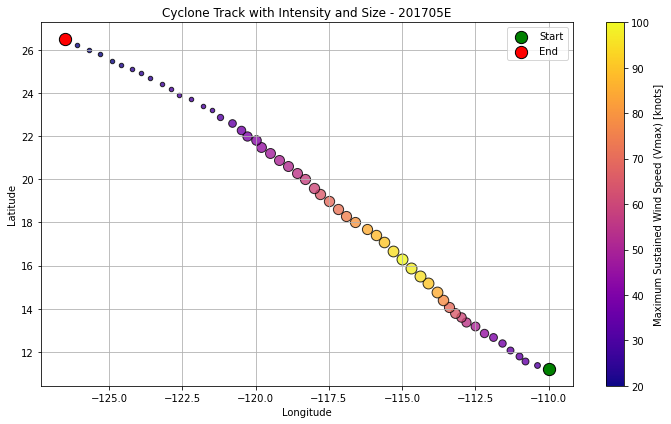

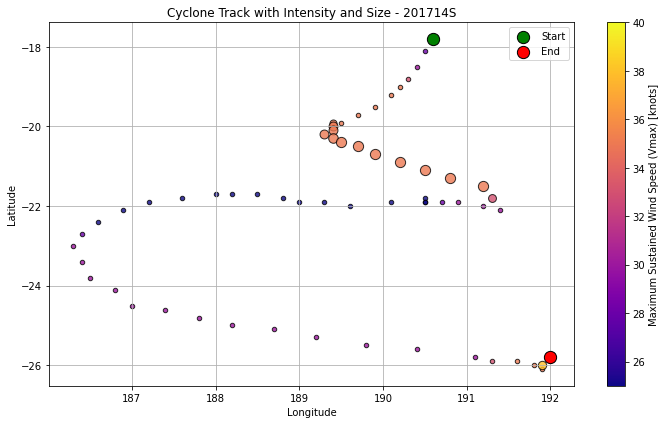

In [61]:
# Example usage
for cid in data_info['ID'].drop_duplicates().sample(3, random_state=42):
    plot_cyclone_track_with_size(data_info, cid)

##  Trajectory Plot with MSLP

In [62]:
def plot_cyclone_track_with_mslp(df, storm_id):
    track = df[df['ID'] == storm_id].sort_values('time')  # 'time' is used instead of datetime here

    lats = track['lat'].values
    lons = track['lon'].values
    mslp = track['MSLP'].values

    # Normalize MSLP for color mapping
    norm = mcolors.Normalize(vmin=np.min(mslp), vmax=np.max(mslp))
    cmap = cm.get_cmap('coolwarm_r')  # lower pressure = warmer color (more intense)

    plt.figure(figsize=(10, 6))

    # Plot trajectory with color mapped to MSLP
    scatter = plt.scatter(lons, lats, c=mslp, cmap=cmap, norm=norm, s=100, edgecolor='black')

    # Annotate start and end
    plt.scatter(lons[0], lats[0], color='lime', s=200, edgecolor='black', label='Start', zorder=5)
    plt.scatter(lons[-1], lats[-1], color='red', s=200, edgecolor='black', label='End', zorder=5)

    # Add labels every few steps
    for i in range(0, len(track), 5):
        plt.text(lons[i]+0.2, lats[i], f"{int(mslp[i])} hPa", fontsize=8, color='navy')

    # Add colorbar for MSLP
    cbar = plt.colorbar(scatter)
    cbar.set_label('MSLP (hPa)', fontsize=11)

    plt.title(f"Cyclone Track of {storm_id} with MSLP", fontsize=13)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


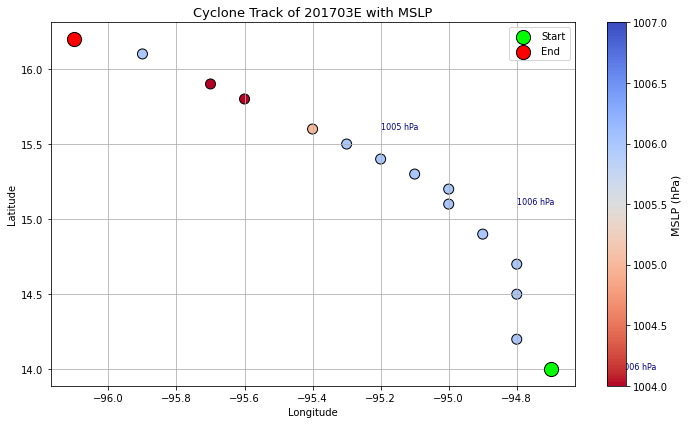

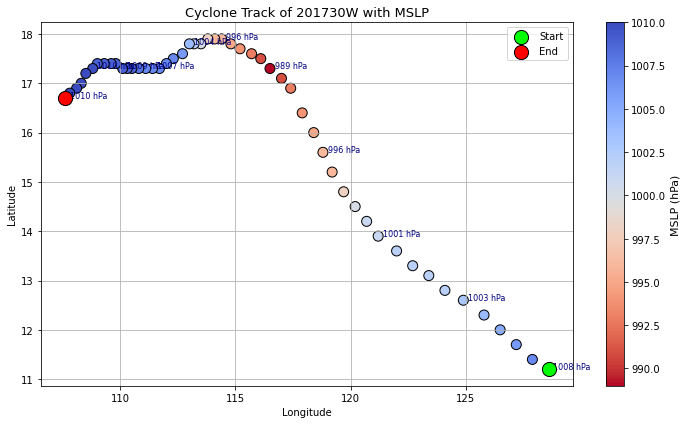

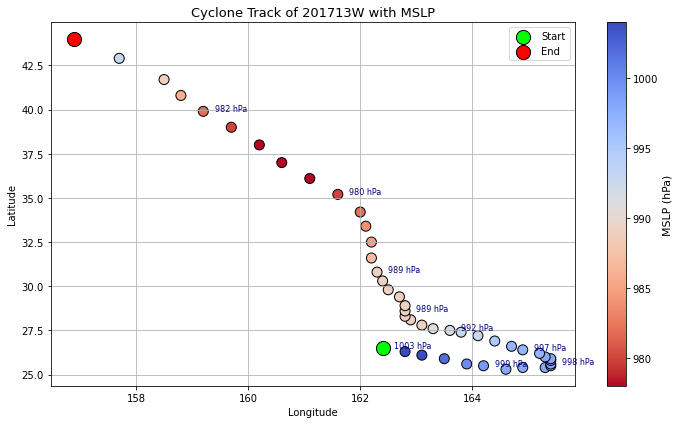

In [63]:
# Plot 3 cyclone tracks with MSLP color-coded
for cid in data_info['ID'].drop_duplicates().sample(3, random_state=7):
    plot_cyclone_track_with_mslp(data_info, cid)


In [64]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_cyclone_image_with_track_and_mslp(df, storm_id, data_matrix):
    # Extract track info for the given storm ID
    track = df[df['ID'] == storm_id].sort_values('time')

    # Get latitude, longitude, and MSLP values
    lats = track['lat'].values
    lons = track['lon'].values
    mslp = track['MSLP'].values

    # Convert 'time' to a datetime format and get the indices of the closest images
    time = track['time'].values
    time_idx = []
    for t in time:
        # Convert time to string or integer format (you can choose based on your data)
        # Assuming 'time' is in the format 'YYYYMMDDHH' and can be mapped directly to the matrix
        time_idx.append(np.where(data_info['time'] == t)[0][0])

    # Get the cyclone image corresponding to each time step
    # For each step, grab the image from the data_matrix
    cyclone_images = [data_matrix[idx] for idx in time_idx]

    # Normalize MSLP for color mapping
    norm = mcolors.Normalize(vmin=np.min(mslp), vmax=np.max(mslp))
    cmap = cm.get_cmap('coolwarm_r')

    plt.figure(figsize=(10, 6))

    # Plot the cyclone image and trajectory for each time step
    for i in range(len(time_idx)):
        plt.imshow(cyclone_images[i][:, :, 0], extent=[np.min(lons), np.max(lons), np.min(lats), np.max(lats)], alpha=0.6)

        # Plot trajectory with color mapped to MSLP
        scatter = plt.scatter(lons[i], lats[i], c=mslp[i], cmap=cmap, norm=norm, s=100, edgecolor='black')

        # Annotate start and end with colors (for easy identification)
        if i == 0:
            plt.scatter(lons[i], lats[i], color='lime', s=200, edgecolor='black', label='Start', zorder=5)
        elif i == len(time_idx) - 1:
            plt.scatter(lons[i], lats[i], color='red', s=200, edgecolor='black', label='End', zorder=5)

    # Add colorbar for MSLP
    cbar = plt.colorbar(scatter)
    cbar.set_label('MSLP (hPa)', fontsize=11)

    # Add title and labels
    plt.title(f"Cyclone Track of {storm_id} with MSLP", fontsize=13)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

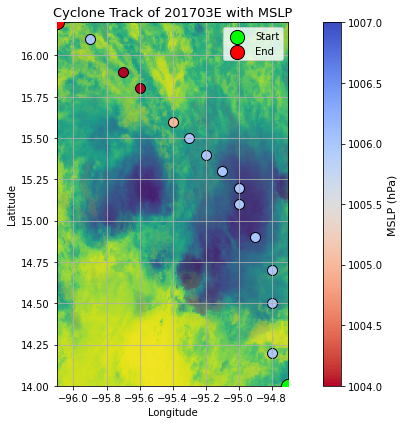

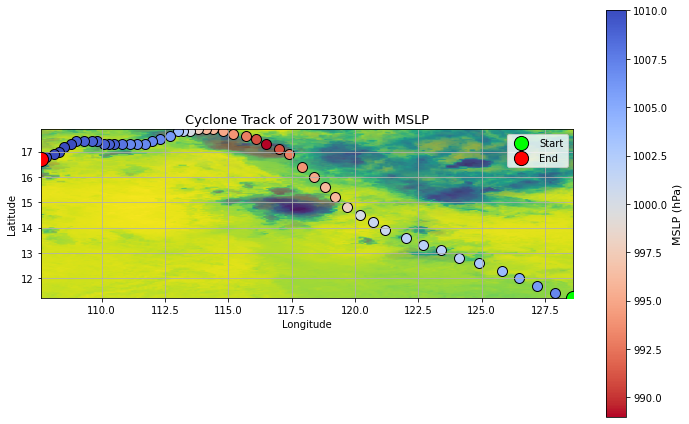

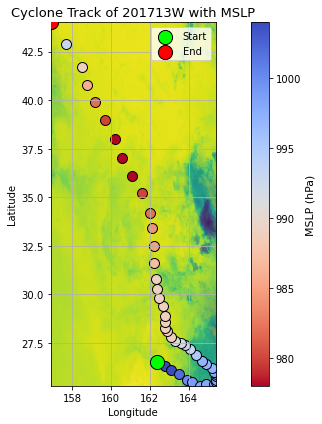

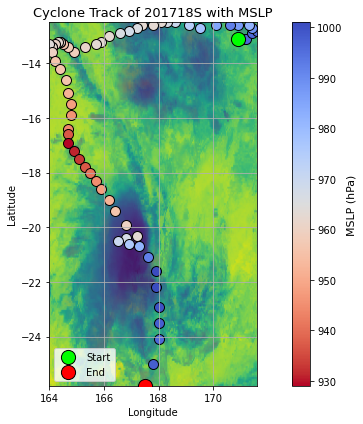

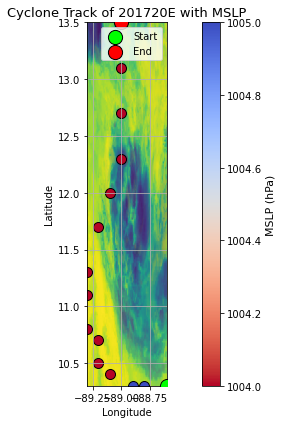

C:\Users\ASUS\anaconda3\lib\site-packages\matplotlib\image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\ASUS\anaconda3\lib\site-packages\matplotlib\image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\ASUS\anaconda3\lib\site-packages\matplotlib\image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


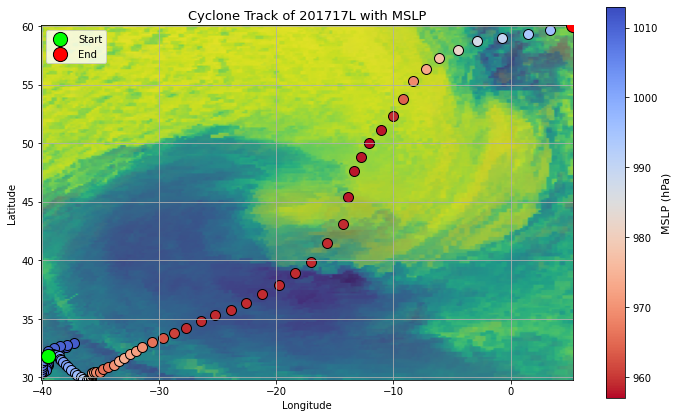

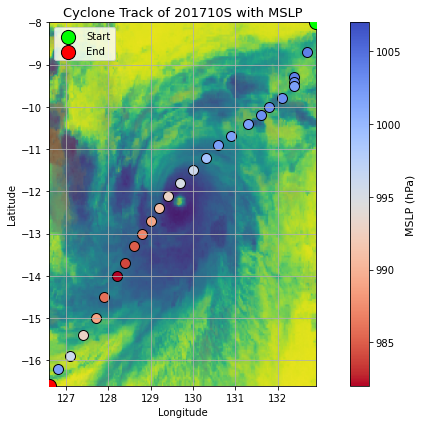

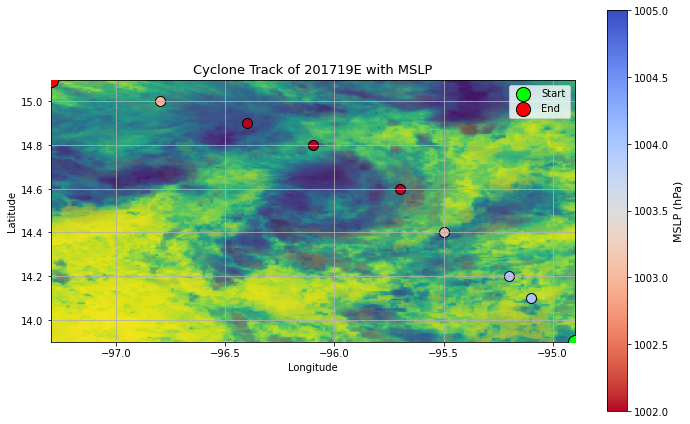

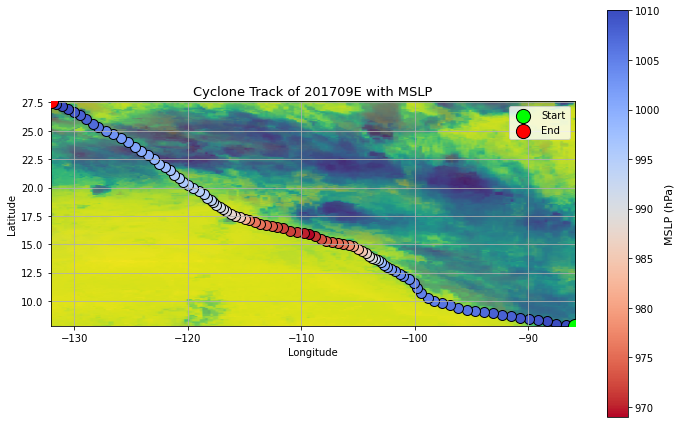

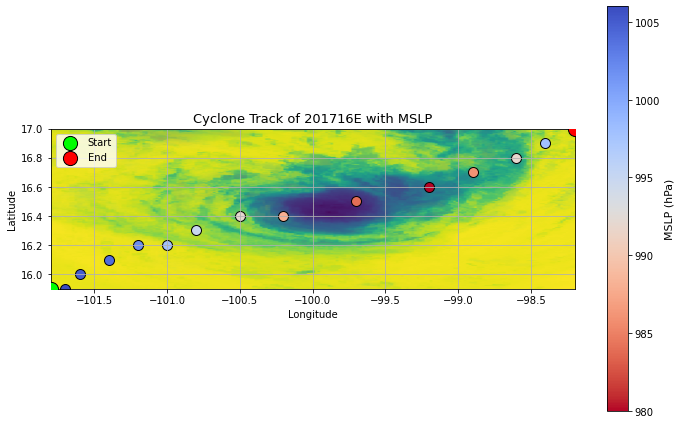

In [65]:
# Plot cyclone track along with the image for 3 random cyclones
for cid in data_info['ID'].drop_duplicates().sample(10, random_state=7):
    plot_cyclone_image_with_track_and_mslp(data_info, cid, data_matrix)


## Displacement Analysis (Speed & Direction)

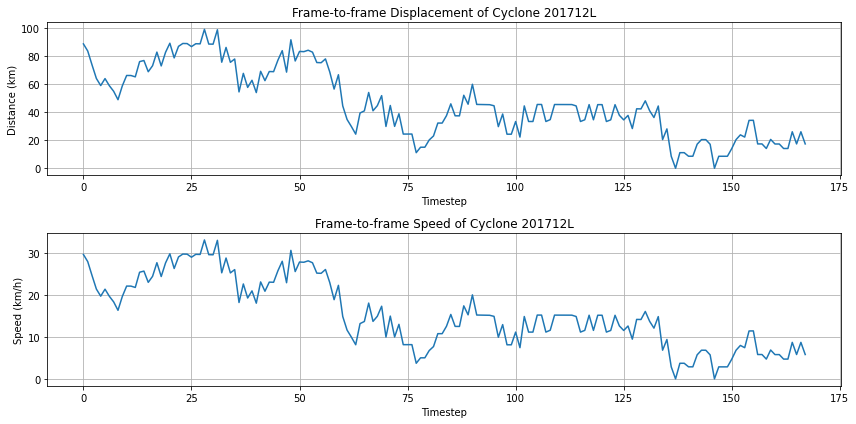

Average speed of Cyclone 201712L: 15.53 km/h


In [66]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Haversine function to calculate the great-circle distance between two points
def haversine(pt1, pt2):
    # Radius of the Earth in kilometers
    R = 6371.0
    lat1, lon1 = pt1
    lat2, lon2 = pt2
    
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c  # in kilometers
    return distance

# Compute the displacement and speed between consecutive cyclone positions
def compute_displacement_and_speed(track_df):
    track_df = track_df.sort_values('datetime').reset_index(drop=True)
    displacements = []
    speeds = []
    
    # Calculate displacement and speed
    for i in range(1, len(track_df)):
        # Get the coordinates (latitude, longitude)
        pt1 = (track_df.loc[i-1, 'lat'], track_df.loc[i-1, 'lon'])
        pt2 = (track_df.loc[i, 'lat'], track_df.loc[i, 'lon'])
        
        # Calculate displacement in km
        d = haversine(pt1, pt2)
        displacements.append(d)
        
        # Calculate time difference between consecutive points in hours
        t1 = datetime.strptime(str(track_df.loc[i-1, 'time']), '%Y%m%d%H')
        t2 = datetime.strptime(str(track_df.loc[i, 'time']), '%Y%m%d%H')
        time_diff = (t2 - t1).total_seconds() / 3600  # Convert time difference to hours
        
        # Calculate speed in km/h (distance/time)
        speed = d / time_diff if time_diff > 0 else 0
        speeds.append(speed)
    
    return displacements, speeds

# Apply on the longest cyclone (example_id needs to be set)
example_id = data_info['ID'].value_counts().idxmax()  # Get the ID of the longest cyclone
track = data_info[data_info['ID'] == example_id]

# Compute displacement and speed
dists, speeds = compute_displacement_and_speed(track)

# Plot displacement
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(dists)
plt.title(f'Frame-to-frame Displacement of Cyclone {example_id}')
plt.xlabel('Timestep')
plt.ylabel('Distance (km)')
plt.grid(True)

# Plot speed
plt.subplot(2, 1, 2)
plt.plot(speeds)
plt.title(f'Frame-to-frame Speed of Cyclone {example_id}')
plt.xlabel('Timestep')
plt.ylabel('Speed (km/h)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print average speed over the whole track (in km/h)
average_speed = np.mean(speeds)
print(f'Average speed of Cyclone {example_id}: {average_speed:.2f} km/h')


## Track Curvature / Turning Angles

<ipython-input-67-bcdd3f844357>:23: RuntimeWarning: invalid value encountered in double_scalars
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))


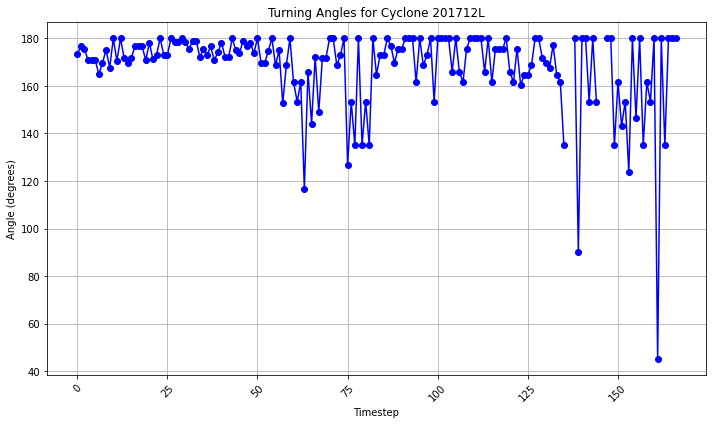

Mean Turning Angle: nan degrees
Max Turning Angle: nan degrees
Min Turning Angle: nan degrees


In [67]:
def compute_turning_angles_with_time(track_df):
    """
    Calculate the turning angles between consecutive cyclone positions.
    The turning angle is the angle between two consecutive vectors formed by three consecutive points.
    """
    track_df = track_df.sort_values('datetime').reset_index(drop=True)
    angles = []
    
    for i in range(1, len(track_df)-1):
        # Get the previous, current, and next positions
        A = np.array([track_df.loc[i-1, 'lon'], track_df.loc[i-1, 'lat']])
        B = np.array([track_df.loc[i, 'lon'], track_df.loc[i, 'lat']])
        C = np.array([track_df.loc[i+1, 'lon'], track_df.loc[i+1, 'lat']])
        
        # Calculate vectors BA and BC
        ba = A - B
        bc = C - B
        
        # Calculate cosine of the angle between vectors BA and BC
        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        
        # Ensure cosine angle is within valid range to avoid NaN due to numerical issues
        angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
        
        # Convert the angle from radians to degrees
        angles.append(np.degrees(angle))
    
    return angles

# Apply on the cyclone data
angles = compute_turning_angles_with_time(track)

# Plot turning angles over time
plt.figure(figsize=(10, 6))
plt.plot(angles, marker='o', linestyle='-', color='b')
plt.title(f'Turning Angles for Cyclone {example_id}')
plt.xlabel('Timestep')
plt.ylabel('Angle (degrees)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optionally print summary statistics
print(f"Mean Turning Angle: {np.mean(angles):.2f} degrees")
print(f"Max Turning Angle: {np.max(angles):.2f} degrees")
print(f"Min Turning Angle: {np.min(angles):.2f} degrees")

## Autocorrelation in Lat/Lon

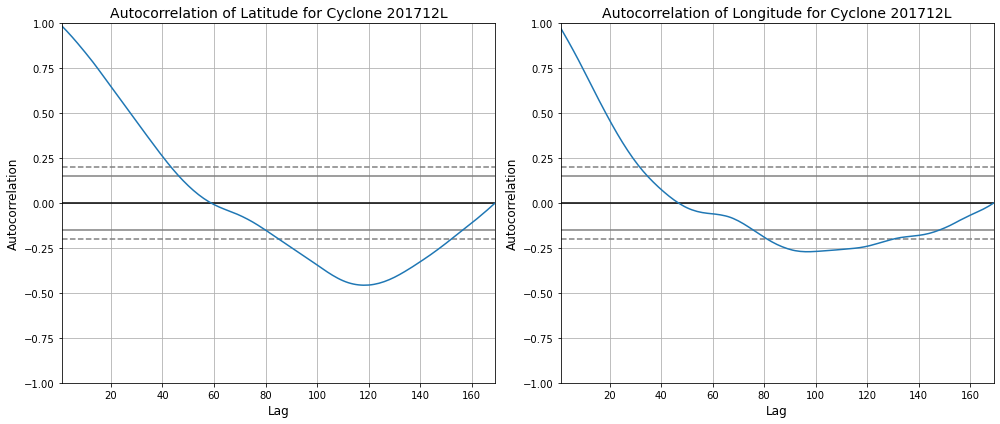

In [68]:
lat_series = track['lat'].reset_index(drop=True)
lon_series = track['lon'].reset_index(drop=True)

# Create a figure for better visualization
plt.figure(figsize=(14, 6))

# Plot autocorrelation for Latitude
plt.subplot(1, 2, 1)
autocorrelation_plot(lat_series)
plt.title(f"Autocorrelation of Latitude for Cyclone {example_id}", fontsize=14)
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.grid(True)

# Plot autocorrelation for Longitude
plt.subplot(1, 2, 2)
autocorrelation_plot(lon_series)
plt.title(f"Autocorrelation of Longitude for Cyclone {example_id}", fontsize=14)
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.grid(True)

# Improve layout to avoid overlap and make it more readable
plt.tight_layout()

# Show the plots
plt.show()

In [69]:
pip install haversine

Note: you may need to restart the kernel to use updated packages.
